In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft2, ifft2
from scipy.integrate import solve_ivp


In [2]:
#code from hw 4 
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags

#parameters: 
m = 64       # -- change 
n = m * m
L = 20 
dx = dy = L/m

# Initialize vectors
e0 = np.zeros((n, 1))  # Vector of zeros
e1 = np.ones((n, 1))   # Vector of ones
e2 = np.copy(e1)       # Copy of e1 one vector
e4 = np.copy(e0)       # Copy of e0 zero vector

for j in range(1, m + 1):
    e2[m * j - 1] = 0     
    e4[m * j - 1] = 1 

e3 = np.zeros_like(e2)
e3[1:] = e2[:-1]
e3[0] = e2[-1]  # Wrap around for periodic boundary

e5 = np.zeros_like(e4)
e5[1:] = e4[:-1] 
e5[0] = e4[-1]  # Wrap around for periodic boundary

diagonals = [
    e1.flatten(),             # -n + m diagonal
    e1.flatten(),             # -m diagonal
    e5.flatten(),             # -m + 1 diagonal
    e2.flatten(),             # -1 diagonal
    (-4 * e1).flatten(),      # Main diagonal (0)
    e3.flatten(),             # +1 diagonal
    e4.flatten(),             # +m - 1 diagonal
    e1.flatten(),             # +m diagonal
    e1.flatten()              # +n - m diagonal
]
offsets = [-(n - m), -m, -m + 1, -1, 0, 1, m - 1, m, (n - m)]
A = spdiags(diagonals, offsets, n, n).toarray() / (dx**2)
A[0, 0] = 2/dx**2

#B: right neighbor - left neighbor 
e1 = np.ones((n, 1)) 
diagonals_B = [e1.flatten(), -e1.flatten(), e1.flatten(),-e1.flatten()]
offsets_B = [-(n - m),-m, m, (n - m)]

B = spdiags(diagonals_B, offsets_B, n, n).toarray()
B /= 2*dx  

#B: right neighbor - left neighbor 
# Define the vectors with specified patterns
e1 = np.zeros((n, 1))
for i in range(0, n, m):
    e1[i] = 1  # Pattern [1, 0, 0, 0, 0, 0, 0, 0]

e2 = np.ones((n, 1))
for i in range(m - 1, n, m):
    e2[i] = 0  # Pattern [1, 1, 1, 1, 1, 1, 1, 0]

e3 = np.ones((n, 1))
for i in range(0, n, m):
    e3[i] = 0  # Pattern [0, 1, 1, 1, 1, 1, 1, 1]

e4 = np.zeros((n, 1))
for i in range(m - 1, n, m):
    e4[i] = 1  # Pattern [0, 0, 0, 0, 0, 0, 0, 1]
    
diagonals_C = [e1.flatten(), -e2.flatten(), e3.flatten(),-e4.flatten()]
offsets_C = [-m+1,-1,1,m-1]

C = spdiags(diagonals_C, offsets_C, n, n).toarray()
C /= 2*dx  

In [3]:
# parameters
tspan = np.arange(0,4.5,0.5) 
nu = 0.001 
Lx, Ly = 20, 20 
nx, ny = 64, 64 
N = nx * ny

# initial conditions
x2 = np.linspace(-Lx/2, Lx/2, nx+1)
x = x2[:nx]
y2 = np.linspace(-Ly/2, Ly/2, ny+1)
y = y2[:ny]
X, Y = np.meshgrid(x, y)

w0 = np.exp(-X**2 -(Y**2 / 20))
w2 = w0.flatten()
# K values 
kx = (2 * np.pi /(Lx)) * np.concatenate((np.arange(0, nx/2), np.arange(-nx/2, 0)))
kx[0] = 1e-6
ky = (2 * np.pi /(Ly)) * np.concatenate((np.arange(0, ny/2), np.arange(-ny/2, 0)))
ky[0] = 1e-6
KX, KY = np.meshgrid(kx, ky)
K = KX**2 + KY**2


In [4]:
# Define the ODE system for the spectral space
def spectral_rhs(t, w2, nx, ny, N, K, nu):
    w = w2.reshape((nx, ny))
    wt = fft2(w)
    psit = -wt / K
    psi = np.real(ifft2(psit)).reshape(N)

    rhs = nu*A.dot(w2)+(B.dot(w2))*(C.dot(psi))-(B.dot(psi))*(C.dot(w2))
    return rhs


In [5]:
# Solve the ODE 
solution = solve_ivp(
    spectral_rhs, [0,4], w2, t_eval=tspan, args=(nx, ny, N, K, nu), method='RK45'
)

A1 = solution.y
print(A1.shape)
print(A1)

(4096, 9)
[[2.50656748e-46 3.59343426e-45 1.89141923e-44 ... 1.90792904e-42
  4.82195572e-42 1.14719429e-41]
 [1.17762859e-43 6.53684735e-43 2.62060754e-42 ... 1.58866557e-40
  3.55916152e-40 7.45533788e-40]
 [4.55107657e-41 1.93087628e-40 6.43663355e-40 ... 2.48966551e-38
  5.07459635e-38 9.69185374e-38]
 ...
 [1.96785570e-38 1.23636238e-37 5.46906656e-37 ... 4.35977114e-35
  1.02335874e-34 2.22858322e-34]
 [6.19028421e-41 5.34124949e-40 2.93882031e-39 ... 3.68664229e-37
  9.45501433e-37 2.23512843e-36]
 [1.60178709e-43 1.99879166e-42 1.41268009e-41 ... 2.80496038e-39
  7.96285822e-39 2.07493092e-38]]


In [6]:
import time
start_time = time.time()  # Record the start time
end_time = time.time()  # Record the end time
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 0.00 seconds


In [7]:
def ab_rhs(t,w2,A, B, C,nu):
    psi = np.linalg.solve(A, w2)
    rhs = nu*A.dot(w2)+(B.dot(w2))*(C.dot(psi))-(B.dot(psi))*(C.dot(w2))
    return rhs

In [8]:
start_time = time.time()
A2 = solve_ivp(ab_rhs,[0,4], w2,t_eval=tspan,args=(A, B, C, nu),method="RK45",).y
elapsed_time_ab = time.time() - start_time

In [9]:
print(f"Elapsed time: {elapsed_time_ab:.2f} seconds")

Elapsed time: 16.72 seconds


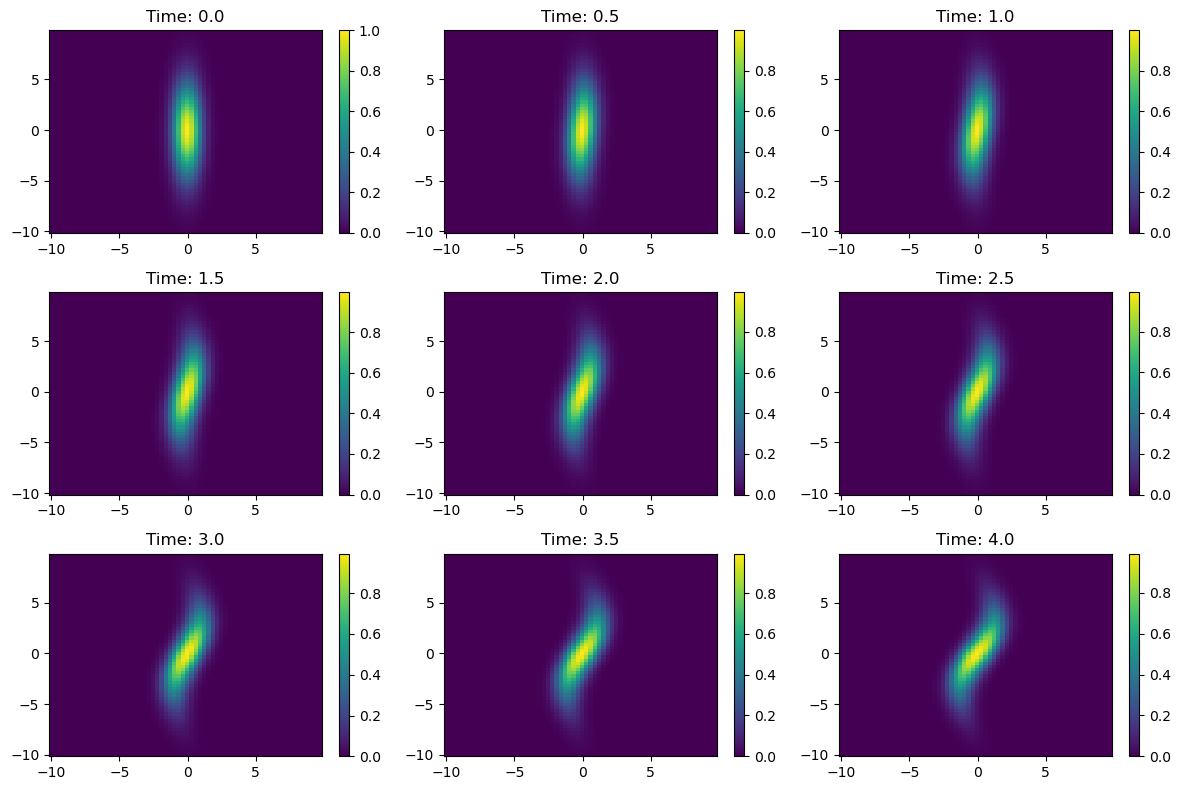

In [10]:
wtsol = A2
rows, cols = 3, 3 
plt.figure(figsize=(12, 8))
for j, t in enumerate(tspan):
    w = wtsol[:,j].reshape((nx, ny))
    plt.subplot(rows, cols, j + 1)
    plt.pcolor(x, y, w, shading='auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [11]:
from scipy.linalg import lu
from scipy.linalg import solve_triangular
P, L, U = lu(A)
def lu_rhs(t, w2, A, B, C, nu):
    Pb = np.dot(P, w2)
    y = solve_triangular(L, Pb, lower=True)
    psi = solve_triangular(U, y)
    
    rhs = nu*A.dot(w2)+(B.dot(w2))*(C.dot(psi))-(B.dot(psi))*(C.dot(w2))
    return rhs

In [12]:
start_time = time.time()
A3=solve_ivp(lu_rhs,(tspan[0], tspan[-1]),w2,t_eval=tspan,args=(A, B, C, nu),method="RK45",).y
elapsed_time_lu = time.time() - start_time

In [13]:
print(f"Elapsed time: {elapsed_time_lu:.2f} seconds")

Elapsed time: 0.88 seconds


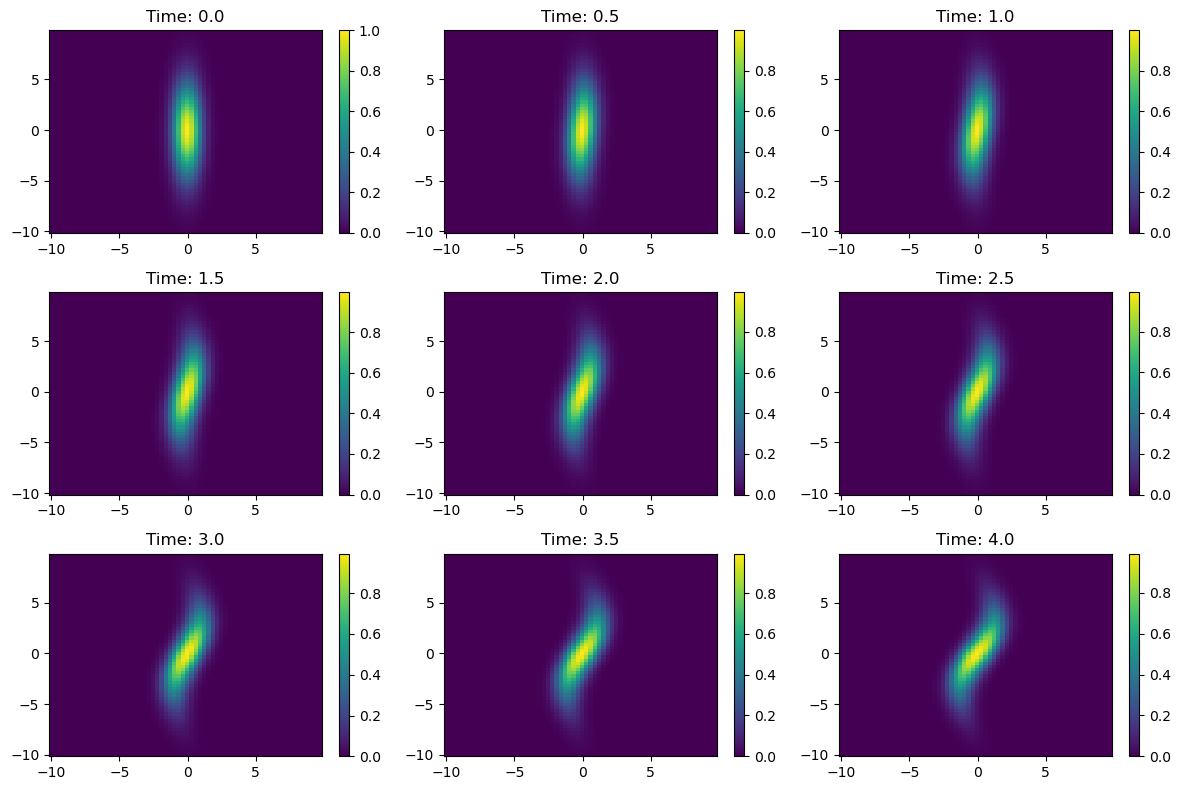

LU Solver Elapsed Time: 0.88 seconds


In [14]:

wtsol = A3
rows, cols = 3, 3 
plt.figure(figsize=(12, 8))
for j, t in enumerate(tspan):
    w = wtsol[:,j].reshape((nx, ny))
    plt.subplot(rows, cols, j + 1)
    plt.pcolor(x, y, w, shading='auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

print(f"LU Solver Elapsed Time: {elapsed_time_lu:.2f} seconds")

In [15]:
# BICGSTAB
from scipy.sparse.linalg import bicgstab 
def bicgstab_rhs(t, w2, A, B, C, nu):
    psi,_ = bicgstab(A, w2)
    rhs = nu * A.dot(w2) + (B.dot(w2)) * (C.dot(psi)) - (B.dot(psi)) * (C.dot(w2))
    return rhs
start_time = time.time()
bicgstab_val = solve_ivp(bicgstab_rhs, [0, 4], w2, t_eval=tspan, args=(A, B, C, nu), method="RK45").y
elapsed_time_bicgstab = time.time() - start_time

In [16]:
print(f"Elapsed time: {elapsed_time_bicgstab:.2f} seconds")

Elapsed time: 45.07 seconds


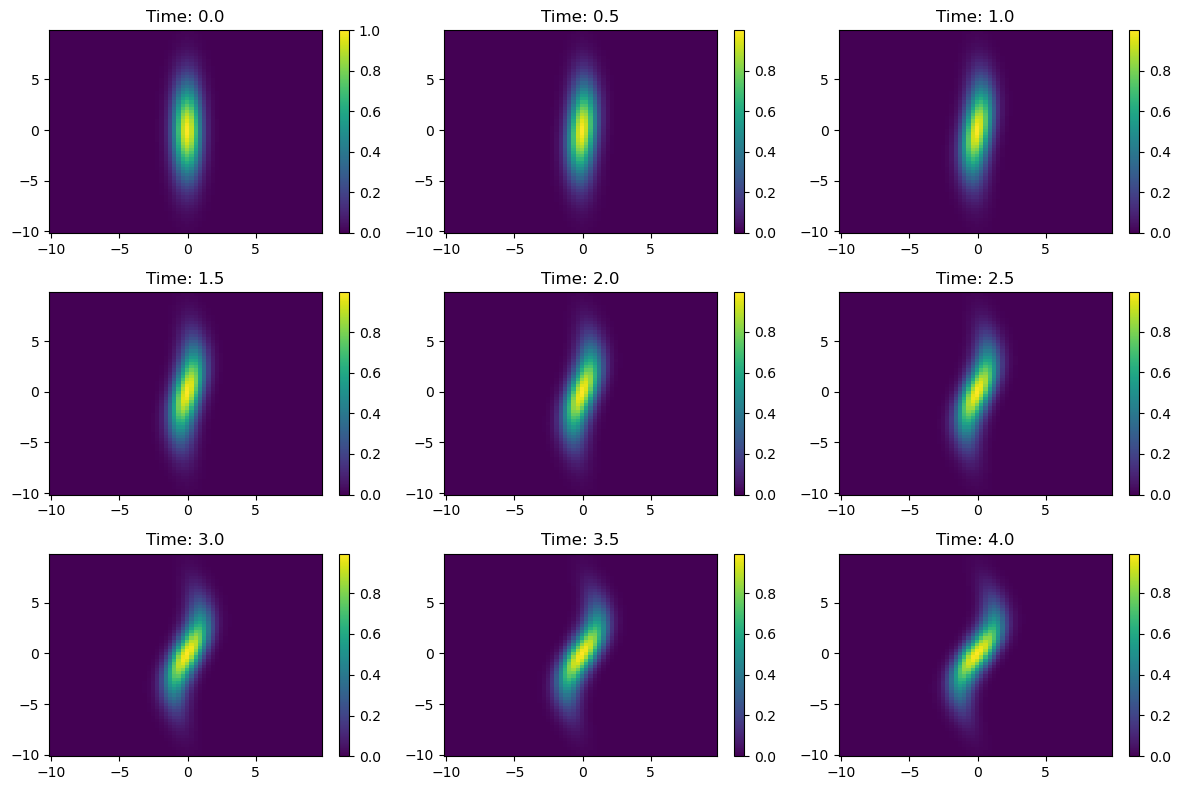

In [17]:
wtsol = bicgstab_val
rows, cols = 3, 3 
plt.figure(figsize=(12, 8))
for j, t in enumerate(tspan):
    w = wtsol[:,j].reshape((nx, ny))
    plt.subplot(rows, cols, j + 1)
    plt.pcolor(x, y, w, shading='auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [18]:
# gmres method 
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import gmres
A = csr_matrix(A)

residuals = []  
def record_residual(rk):
    residuals.append(rk)
    
def ab_rhs_gmres(t, w2, A, B, C, nu):
    
    psi = gmres(A, w2, callback=record_residual)[0]  
    rhs = nu * A.dot(w2) + (B.dot(w2)) * (C.dot(psi)) - (B.dot(psi)) * (C.dot(w2))
    return rhs

start_time = time.time()
gmres_val = solve_ivp(ab_rhs_gmres, [0, 4], w2, t_eval=tspan, args=(A, B, C, nu), method="RK45").y
elapsed_time_gmres = time.time() - start_time

print(gmres_val)

[[ 2.50656748e-46 -1.78574925e-36  1.02584545e-36 ... -5.74326238e-26
  -6.67580915e-25  3.02014436e-24]
 [ 1.17762859e-43 -2.25993258e-29  1.85528847e-29 ... -1.48123706e-19
  -7.81944041e-19  1.67350966e-18]
 [ 4.55107657e-41 -4.24495917e-29  3.48577962e-29 ... -2.19869815e-20
  -2.91438360e-19  1.23873778e-18]
 ...
 [ 1.96785570e-38  7.20611199e-28 -6.58563409e-28 ...  4.01206991e-20
   1.34318839e-19 -8.93702748e-19]
 [ 6.19028421e-41  1.69064720e-28 -1.49156792e-28 ...  3.00103373e-20
   1.75917602e-19 -9.80153558e-19]
 [ 1.60178709e-43  5.05655351e-29 -4.37882781e-29 ...  2.47402619e-20
   1.15690568e-20  3.11220035e-20]]


In [19]:
print(f"Elapsed time: {elapsed_time_gmres:.2f} seconds")

Elapsed time: 17.51 seconds


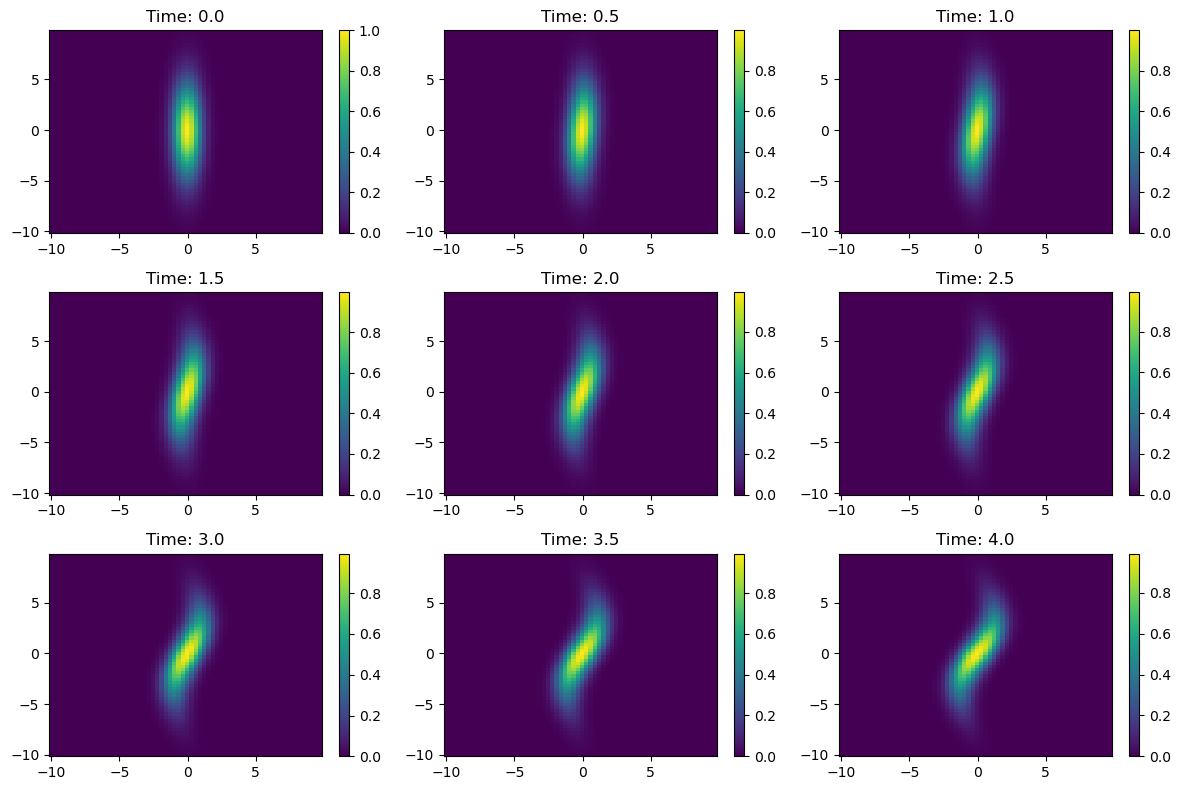

In [20]:
wtsol = gmres_val
rows, cols = 3, 3 
plt.figure(figsize=(12, 8))
for j, t in enumerate(tspan):
    w = wtsol[:,j].reshape((nx, ny))
    plt.subplot(rows, cols, j + 1)
    plt.pcolor(x, y, w, shading='auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


In [21]:
# part c
# Two Oppositely Charged Vortices
x1, y1 = -5, 0  # Position of first vortex
x2, y2 = 5, 0   # Position of second vortex

w_pos = np.exp(-((X - x1)**2 + (Y - y1)**2))  # Positive vortex
w_neg = -np.exp(-((X - x2)**2 + (Y - y2)**2))  # Negative vortex

wcombine = w_pos + w_neg  # Combine into initial condition
wcombine = wcombine.flatten()   # Flatten for solver

# Two Same-Charged Vortices
w_same = np.exp(-((X - x1)**2 + (Y - y1)**2)) + np.exp(-((X - x2)**2 + (Y - y2)**2))
wcombine = w_same.flatten()

# Two Pairs of Oppositely Charged Vortices
x3, y3 = -5, 5  # Position of third vortex
x4, y4 = 5, -5  # Position of fourth vortex

w_pair = (np.exp(-((X - x1)**2 + (Y - y1)**2)) -
          np.exp(-((X - x2)**2 + (Y - y2)**2)) +
          np.exp(-((X - x3)**2 + (Y - y3)**2)) -
          np.exp(-((X - x4)**2 + (Y - y4)**2)))

wcombine = w_pair.flatten()
n_vortices = 10
w_random = np.zeros_like(X)

for _ in range(n_vortices):
    x_vortex, y_vortex = np.random.uniform(-Lx / 2, Lx / 2, 2)
    strength = np.random.uniform(-1, 1)  # Random positive or negative strength
    w_random += strength * np.exp(-((X - x_vortex)**2 + (Y - y_vortex)**2 / 10))

wcombine = w_random.flatten()


In [22]:
# Time evolution
s2_time = time.time()
wtsol = solve_ivp(lu_rhs, [tspan[0], tspan[-1]],wcombine, method="RK45",t_eval=tspan,args=(A, B, C, nu))
e2_time = time.time()

print(f"Computation time: {e2_time - s2_time:.2f} seconds")


Computation time: 11.03 seconds


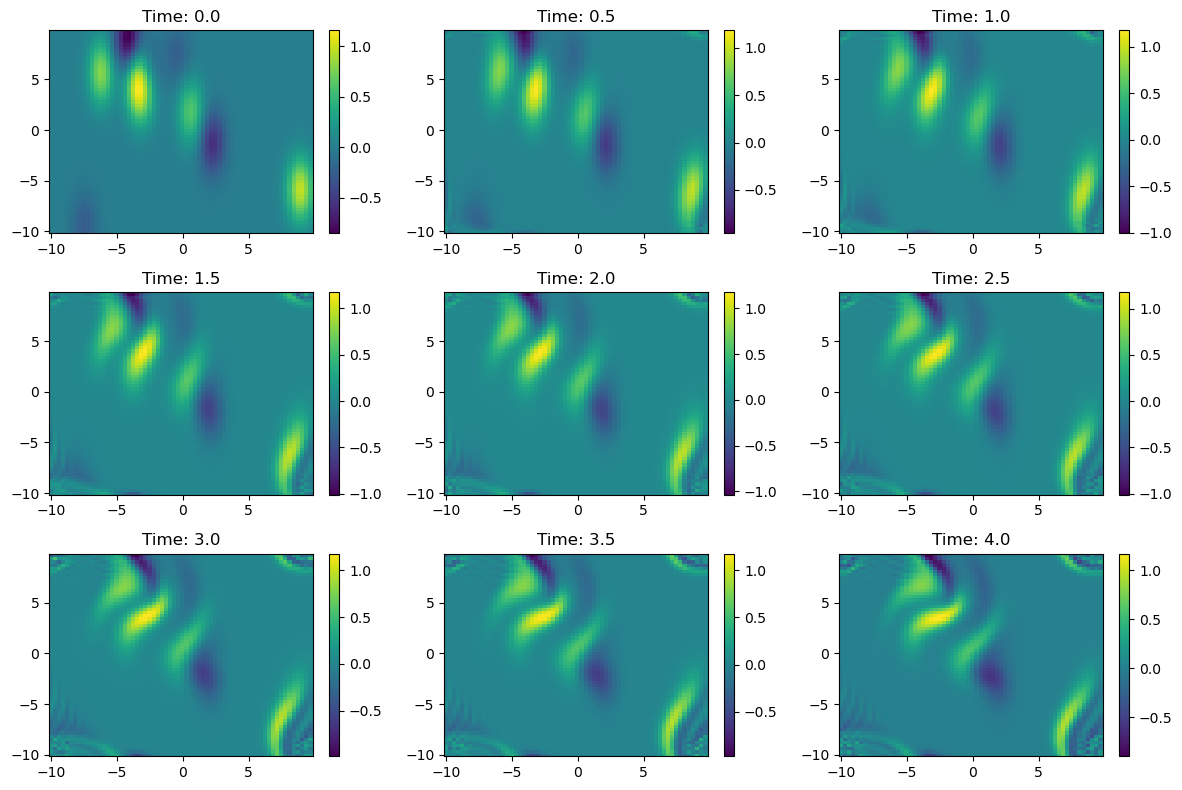

In [23]:
# Visualization
rows, cols = 3, 3 
plt.figure(figsize=(12, 8))

for j, t in enumerate(tspan):
    w =  wtsol.y[:, j].reshape((nx, ny))  
    plt.subplot(rows, cols, j + 1)
    plt.pcolor(x, y, w, shading='auto')  
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()


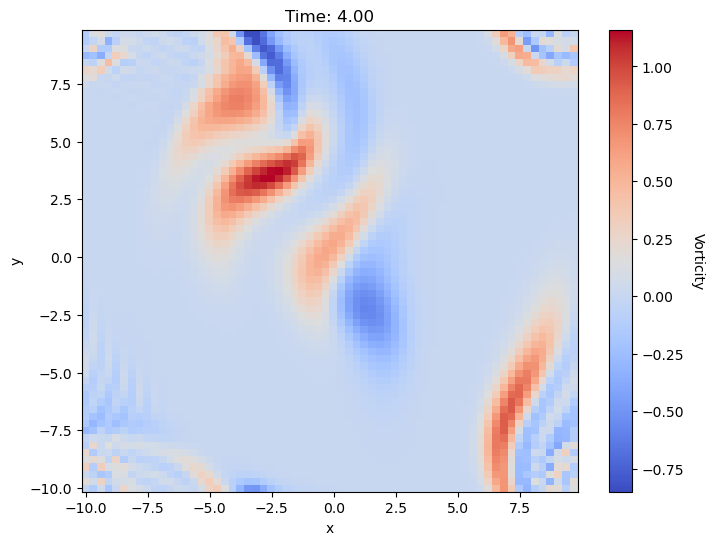

In [25]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Reshape results for animation
vorticity_data = wtsol.y.reshape((nx, ny, len(tspan)))

# Setup figure and axis
fig, ax = plt.subplots(figsize=(8, 6))
cmap = ax.pcolor(x, y, vorticity_data[:, :, 0], cmap='coolwarm', shading='auto')
cbar = fig.colorbar(cmap)
cbar.set_label('Vorticity', rotation=270, labelpad=15)
ax.set_title(f'Time: {tspan[0]}')
ax.set_xlabel('x')
ax.set_ylabel('y')

# Update function for animation
def update(frame):
    cmap.set_array(vorticity_data[:, :, frame].flatten())  # Update data
    ax.set_title(f'Time: {tspan[frame]:.2f}')  # Update time
    return cmap,

# Create animation
ani = FuncAnimation(
    fig, update, frames=len(tspan), interval=200, blit=True
)

# Display animation in Jupyter Notebook
HTML(ani.to_jshtml())  # Use HTML writer to embed animation
